# FACES IN THE WILD

# IMAGE LOADING AND CREATION 

In [1]:
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from pathlib import Path
from types import SimpleNamespace
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score

from autoencoder import train_lfw_autoencoder

In [2]:
def load_lfw_directory(base_dir):
    base_dir = Path(base_dir)
    if not base_dir.exists():
        raise FileNotFoundError(f'LFW directory not found: {base_dir}')

    person_dirs = sorted([d for d in base_dir.iterdir() if d.is_dir()])
    if not person_dirs:
        raise RuntimeError(f'No person subdirectories found in {base_dir}')

    flat_data = []
    images = []
    labels = []

    allowed_ext = {'.jpg', '.jpeg', '.png', '.bmp'}
    height = width = None

    for label, person_dir in enumerate(person_dirs):
        files = sorted([f for f in person_dir.iterdir() if f.suffix.lower() in allowed_ext])
        if not files:
            continue
        for img_path in files:
            with Image.open(img_path) as img:
                img_gray = img.convert('L')
                arr = np.asarray(img_gray, dtype=np.float32) / 255.0

            if height is None and width is None:
                height, width = arr.shape
            elif arr.shape != (height, width):
                raise ValueError(f'Inconsistent image shape {arr.shape} in {img_path}; expected {(height, width)}')

            images.append(arr)
            flat_data.append(arr.reshape(-1))
            labels.append(label)

    if not images:
        raise RuntimeError(f'No images found in {base_dir}')

    images = np.stack(images)
    data = np.stack(flat_data)
    target = np.array(labels, dtype=np.int32)
    target_names = np.array([d.name for d in person_dirs])

    return SimpleNamespace(data=data, target=target, images=images, target_names=target_names)

lfw_root = Path('dataset/Q3/LFW_Dataset')
lfw = load_lfw_directory(lfw_root)

X_lfw = lfw.data.astype('float32')
y_lfw = lfw.target
lfw_images = lfw.images
names = lfw.target_names
names_clean = np.array([n.replace('_', ' ') for n in names])

# Filter out classes with fewer than two images (required for stratified split)
class_counts = np.bincount(y_lfw, minlength=len(names))
keep_classes = np.where(class_counts >= 2)[0]
if len(keep_classes) == 0:
    raise ValueError('No classes with at least two samples were found in the LFW directory.')

if len(keep_classes) < len(names):
    dropped = len(names) - len(keep_classes)
    print(f'Filtered out {dropped} classes with fewer than 2 samples.')

mask = np.isin(y_lfw, keep_classes)
X_lfw = X_lfw[mask]
y_lfw = y_lfw[mask]
lfw_images = lfw_images[mask]

old_to_new = {old: new for new, old in enumerate(keep_classes)}
y_lfw = np.array([old_to_new[int(lbl)] for lbl in y_lfw], dtype=np.int32)
names = names[keep_classes]
names_clean = names_clean[keep_classes]
class_counts = class_counts[keep_classes]

print(f'LFW shape: {X_lfw.shape}')
print(f'Classes ({len(names)}): {names_clean}')
print(f'Class distribution: {class_counts}')
print(f'Image resolution: {lfw_images.shape[1]} x {lfw_images.shape[2]}')

Filtered out 4069 classes with fewer than 2 samples.
LFW shape: (9164, 62500)
Classes (1680): ['Aaron Peirsol' 'Aaron Sorkin' 'Abdel Nasser Assidi' ... 'Zico'
 'Zinedine Zidane' 'Zoran Djindjic']
Class distribution: [4 2 2 ... 3 6 4]
Image resolution: 250 x 250


In [3]:
# Split into train/test and prepare normal class (George W Bush)
target_name = 'George W Bush'
normalized_names = np.array([n.replace('_', ' ').lower() for n in names])
matches = np.where(normalized_names == target_name.lower())[0]
if len(matches) == 0:
    available = ', '.join(names_clean)
    raise ValueError(f"Could not find '{target_name}' in available classes: {available}")
gwb_idx = matches[0]
print(f"George W Bush class index: {gwb_idx} (stored label: {names[gwb_idx]})")

# Train/test split (80/20)
X_lfw_train, X_lfw_test, y_lfw_train, y_lfw_test = train_test_split(
    X_lfw, y_lfw, test_size=0.2, stratify=y_lfw, random_state=42
)

# Extract George W Bush images for training (normal class)
normal_train = X_lfw_train[y_lfw_train == gwb_idx]
print(f'Normal training samples: {len(normal_train)}')

George W Bush class index: 532 (stored label: George_W_Bush)
Normal training samples: 424


In [4]:
def compute_reconstruction_errors(model, X, mean=None, std=None, batch_size=256):
    """Compute per-sample reconstruction MSE in original pixel space."""
    X = np.asarray(X, dtype=np.float32)

    if mean is not None and std is not None:
        mean = mean.astype(np.float32)
        std = std.astype(np.float32)
        X_proc = (X - mean) / std
    else:
        X_proc = X

    errors = []
    for i in range(0, len(X_proc), batch_size):
        batch = X_proc[i:i+batch_size]
        recon_batch = model.predict(batch)
        if mean is not None and std is not None:
            recon_batch = recon_batch * std + mean
        diff = X[i:i+batch_size] - recon_batch
        errors.append(np.mean(diff ** 2, axis=1))

    return np.concatenate(errors)

In [5]:
def compute_reconstruction_errors(model, X, mean=None, std=None, batch_size=256):
    """Compute per-sample reconstruction MSE in original pixel space."""
    X = np.asarray(X, dtype=np.float32)

    if mean is not None and std is not None:
        mean = mean.astype(np.float32)
        std = std.astype(np.float32)
        X_proc = (X - mean) / std
    else:
        X_proc = X

    errors = []
    for i in range(0, len(X_proc), batch_size):
        batch = X_proc[i:i+batch_size]
        recon_batch = model.predict(batch)
        if mean is not None and std is not None:
            recon_batch = recon_batch * std + mean
        diff = X[i:i+batch_size] - recon_batch
        errors.append(np.mean(diff ** 2, axis=1))

    return np.concatenate(errors)

In [6]:
def evaluate_anomaly_detection(errors, y_true, normal_class_idx, flip_if_needed=True):
    """
    Evaluate anomaly detection performance
    y_true: actual class labels
    normal_class_idx: index of normal class
    Higher score -> anomaly (flipped automatically if needed)
    """
    scores = np.asarray(errors, dtype=np.float32).reshape(-1)
    y_true = np.asarray(y_true)
    y_binary = (y_true != normal_class_idx).astype(int)

    normal_mask = (y_binary == 0)
    anomaly_mask = (y_binary == 1)
    if not np.any(anomaly_mask):
        raise ValueError('No anomaly samples present to evaluate.')

    normal_mean = float(np.mean(scores[normal_mask]))
    anomaly_mean = float(np.mean(scores[anomaly_mask]))

    flipped = False
    if flip_if_needed and anomaly_mean <= normal_mean:
        scores = -scores
        flipped = True

    fpr, tpr, thresholds = roc_curve(y_binary, scores)
    roc_auc = auc(fpr, tpr)

    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thresh = thresholds[best_idx]

    y_pred = (scores > best_thresh).astype(int)

    prec = precision_score(y_binary, y_pred, zero_division=0)
    rec = recall_score(y_binary, y_pred, zero_division=0)
    f1 = f1_score(y_binary, y_pred, zero_division=0)

    return {
        'auc': roc_auc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'threshold': best_thresh,
        'fpr': fpr,
        'tpr': tpr,
        'y_binary': y_binary,
        'y_pred': y_pred,
        'scores': scores,
        'errors': np.asarray(errors, dtype=np.float32),
        'flipped': flipped,
        'normal_mean': normal_mean,
        'anomaly_mean': anomaly_mean
    }

In [7]:
# Train autoencoder on normal class (George W Bush)
lfw_ae, lfw_losses, lfw_mean, lfw_std = train_lfw_autoencoder(
    bottleneck_dim=64,
    X_normal=normal_train
)

In [8]:
# Evaluate on test set
print('Computing reconstruction errors...')
test_errors = compute_reconstruction_errors(lfw_ae, X_lfw_test, lfw_mean, lfw_std)
results = evaluate_anomaly_detection(test_errors, y_lfw_test, gwb_idx)

print(f"\nAnomaly Detection Results:")
print(f"AUC Score: {results['auc']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1-Score: {results['f1']:.4f}")
print(f"Optimal Threshold: {results['threshold']:.6f}")

Computing reconstruction errors...

Anomaly Detection Results:
AUC Score: 0.5691
Precision: 0.9683
Recall: 0.3179
F1-Score: 0.4786
Optimal Threshold: 0.069634


# Bottleneck Dimension Analysis

In [9]:
# Test three different bottleneck dimensions
bottleneck_dims = [32, 64, 128]
models = {}
scalers = {}
loss_history = {}
all_results = {}

for dim in bottleneck_dims:
    print(f'\n=== Training with bottleneck dimension: {dim} ===')
    model, losses, mean, std = train_lfw_autoencoder(
        bottleneck_dim=dim,
        X_normal=normal_train
    )

    print('Computing errors...')
    errors = compute_reconstruction_errors(model, X_lfw_test, mean, std)
    res = evaluate_anomaly_detection(errors, y_lfw_test, gwb_idx)

    models[dim] = model
    scalers[dim] = (mean, std)
    loss_history[dim] = losses
    all_results[dim] = res

    flip_note = ' (flipped scores)' if res['flipped'] else ''
    print(f"AUC: {res['auc']:.4f}, F1: {res['f1']:.4f}{flip_note}")


=== Training with bottleneck dimension: 32 ===


Computing errors...
AUC: 0.5692, F1: 0.4735

=== Training with bottleneck dimension: 64 ===
Computing errors...
AUC: 0.5638, F1: 0.5455

=== Training with bottleneck dimension: 128 ===
Computing errors...
AUC: 0.5694, F1: 0.5656


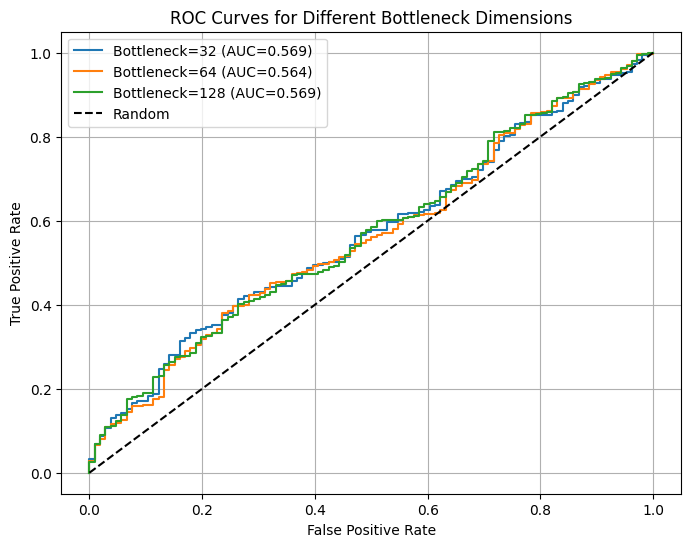


Summary:
Bottleneck 32: AUC=0.5692, Precision=0.9695, Recall=0.3133, F1=0.4735
Bottleneck 64: AUC=0.5638, Precision=0.9633, Recall=0.3804, F1=0.5455
Bottleneck 128: AUC=0.5694, Precision=0.9611, Recall=0.4007, F1=0.5656


In [10]:
# Plot ROC curves for all bottleneck dimensions
plt.figure(figsize=(8, 6))

for dim in bottleneck_dims:
    res = all_results[dim]
    plt.plot(res['fpr'], res['tpr'], label=f'Bottleneck={dim} (AUC={res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Bottleneck Dimensions')
plt.legend()
plt.grid(True)
plt.show()

# Print summary
print("\nSummary:")
for dim in bottleneck_dims:
    res = all_results[dim]
    print(f"Bottleneck {dim}: AUC={res['auc']:.4f}, Precision={res['precision']:.4f}, Recall={res['recall']:.4f}, F1={res['f1']:.4f}")

## Visualisation of BEST Model resilt

In [11]:

# Select best model by AUC
best_dim = max(bottleneck_dims, key=lambda d: all_results[d]['auc'])
best_model = models[best_dim]
best_mean, best_std = scalers[best_dim]
best_res = all_results[best_dim]

print(f'Best model: Bottleneck dimension = {best_dim}')
print(f"AUC: {best_res['auc']:.4f}")
if best_res['flipped']:
    print('Score direction flipped so higher values indicate anomalies.')

test_errors = best_res['errors']
test_scores = best_res['scores']
y_binary = best_res['y_binary']
y_pred = best_res['y_pred']

Best model: Bottleneck dimension = 128
AUC: 0.5694


In [12]:
def find_example(y_true, y_pred, target_true, target_pred):
    """Find index of example with given true/pred labels"""
    mask = (y_true == target_true) & (y_pred == target_pred)
    indices = np.where(mask)[0]
    return indices[0] if len(indices) > 0 else None

# Find examples: TN, TP, FP, FN
tn_idx = find_example(y_binary, y_pred, 0, 0)  # True Negative (correct normal)
tp_idx = find_example(y_binary, y_pred, 1, 1)  # True Positive (correct anomaly)
fp_idx = find_example(y_binary, y_pred, 0, 1)  # False Positive (normal classified as anomaly)
fn_idx = find_example(y_binary, y_pred, 1, 0)  # False Negative (anomaly classified as normal)

print(f'TN: {tn_idx}, TP: {tp_idx}, FP: {fp_idx}, FN: {fn_idx}')

TN: 10, TP: 0, FP: 13, FN: 2


=== Correct Classifications ===


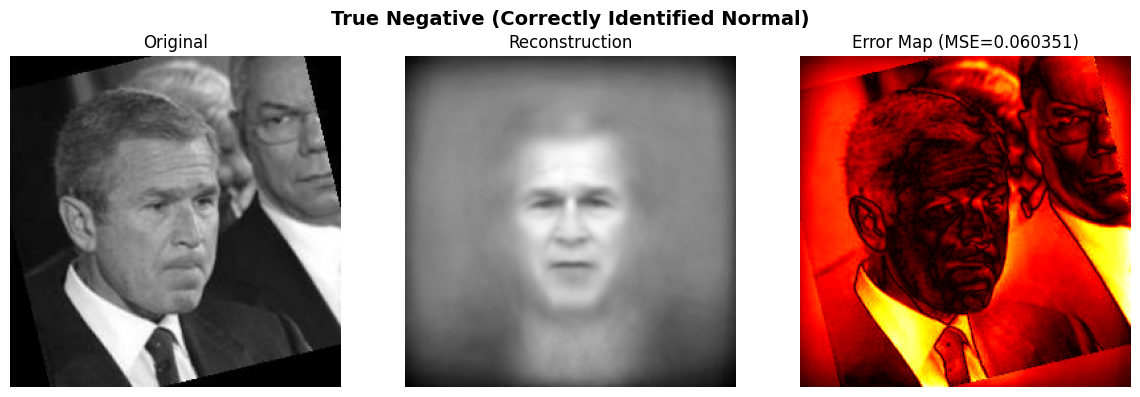

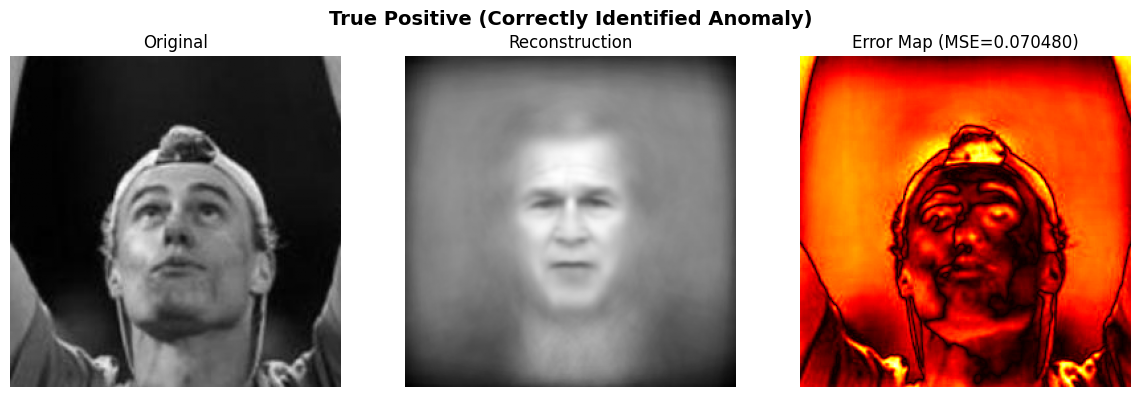


=== Misclassifications ===


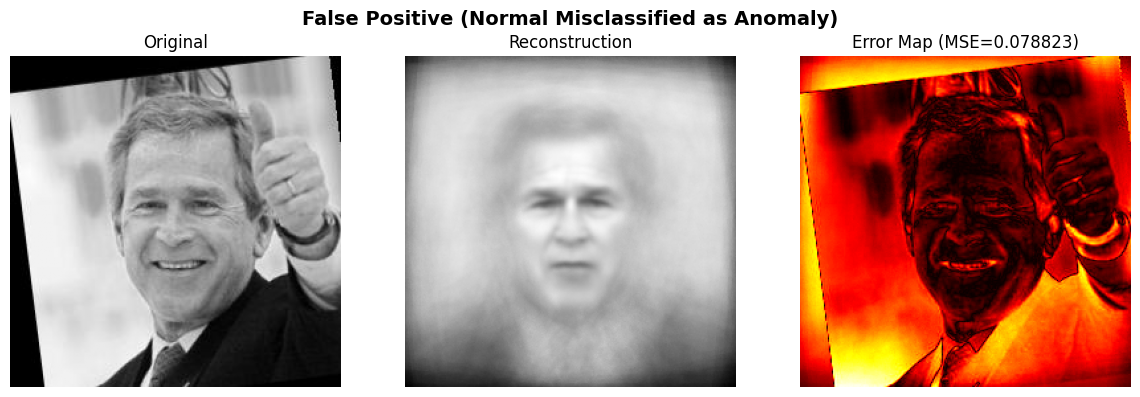

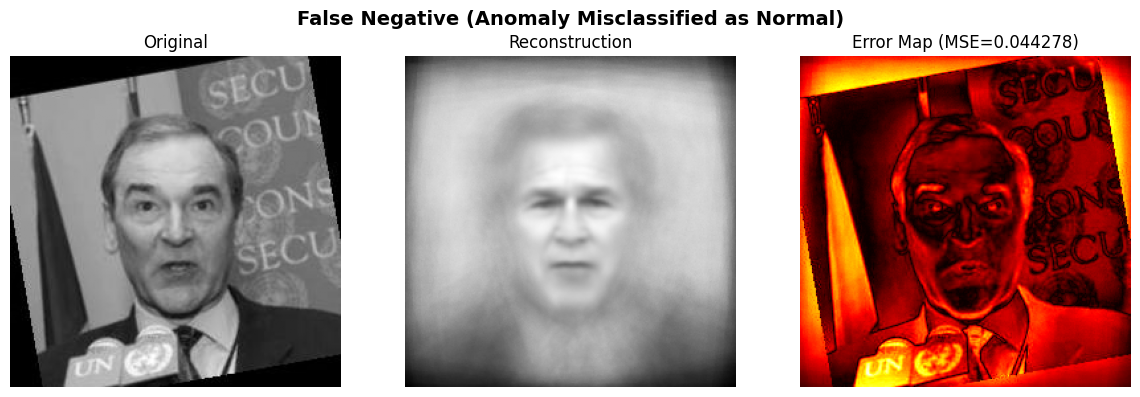

In [13]:
def visualize_example(model, X, idx, error, title, img_shape=(62, 47), mean=None, std=None):
    """Visualize original, reconstruction, and absolute error."""
    if idx is None:
        print(f'No example found for {title}')
        return

    original = X[idx:idx+1].astype(np.float32)
    if mean is not None and std is not None:
        norm = (original - mean) / std
        recon = model.predict(norm) * std + mean
    else:
        recon = model.predict(original)
    recon = np.clip(recon, 0.0, 1.0)
    diff = np.abs(original - recon)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original.reshape(img_shape), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(recon.reshape(img_shape), cmap='gray')
    axes[1].set_title('Reconstruction')
    axes[1].axis('off')

    axes[2].imshow(diff.reshape(img_shape), cmap='hot')
    axes[2].set_title(f'Error Map (MSE={error:.6f})')
    axes[2].axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize all four cases
img_shape = (lfw_images.shape[1], lfw_images.shape[2])

print("=== Correct Classifications ===")
visualize_example(best_model, X_lfw_test, tn_idx, test_errors[tn_idx], 
                  'True Negative (Correctly Identified Normal)', img_shape, best_mean, best_std)
visualize_example(best_model, X_lfw_test, tp_idx, test_errors[tp_idx], 
                  'True Positive (Correctly Identified Anomaly)', img_shape, best_mean, best_std)

print("\n=== Misclassifications ===")
visualize_example(best_model, X_lfw_test, fp_idx, test_errors[fp_idx], 
                  'False Positive (Normal Misclassified as Anomaly)', img_shape, best_mean, best_std)
visualize_example(best_model, X_lfw_test, fn_idx, test_errors[fn_idx], 
                  'False Negative (Anomaly Misclassified as Normal)', img_shape, best_mean, best_std)

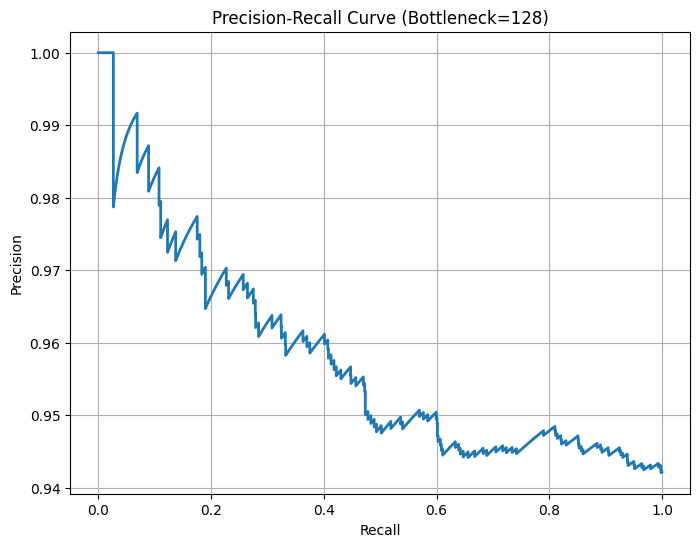


Best Model Performance:
Bottleneck Dimension: 128
AUC: 0.5694
Precision: 0.9611
Recall: 0.4007
F1-Score: 0.5656


In [14]:
# Plot Precision-Recall curve for best model
precision, recall, _ = precision_recall_curve(y_binary, test_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Bottleneck={best_dim})')
plt.grid(True)
plt.show()

print(f'\nBest Model Performance:')
print(f'Bottleneck Dimension: {best_dim}')
print(f"AUC: {best_res['auc']:.4f}")
print(f"Precision: {best_res['precision']:.4f}")
print(f"Recall: {best_res['recall']:.4f}")
print(f"F1-Score: {best_res['f1']:.4f}")